<a href="https://colab.research.google.com/github/carlamaziero/Reconhecimento_padroes/blob/main/Aula5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.14


In [2]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:,2:], iris.target

In [3]:
import numpy as np
import math



def impureza(y): 
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result



def impurezaValor(x, y, valor):
    maiores = x > valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = impurezaMaiores*propMaiores + impurezaMenores*propMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores

In [4]:
def melhorValor1(x, y):
   result = None
   menorImpureza = float('inf')
   xmax = np.max(x)
   xmin = np.min(x)
   while True:
        valor = math.sqrt(xmin*xmax) # média geométrica
        impTotal, impMaiores, impMenores =  impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
   return result, menorImpureza

melhorValor1(X[:,0], y)

(2.6267851073127395, 0.3333333333333333)

In [5]:
def melhorValor2(x, y):
   result = None
   menorImpureza = float('inf')
   xmax = np.max(x)
   xmin = np.min(x)
   while True:
        valor = (xmin+xmax)/2 # média aritmética
        impTotal, impMaiores, impMenores =  impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
   return result, menorImpureza

melhorValor2(X[:,0], y)

(2.475, 0.3333333333333333)

In [6]:
def melhorCaracteristica1(X, y):
    impurezas = []
    valores =  []
    for caracteristica in range(X.shape[1]):
      valor, imp = melhorValor1(X[:, caracteristica], y)
      impurezas.append(imp) 
      valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

melhorCaracteristica1(X, y)

(0, 2.6267851073127395, 0.3333333333333333)

In [7]:
def melhorCaracteristica2(X, y):
    impurezas = []
    valores =  []
    for caracteristica in range(X.shape[1]):
      valor, imp = melhorValor2(X[:, caracteristica], y)
      impurezas.append(imp) 
      valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

melhorCaracteristica2(X, y)

(0, 2.475, 0.3333333333333333)

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore1(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica1(X, y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore1()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore1()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

In [9]:
class Arvore2(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica2(X, y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore2()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore2()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


for Algoritmo in [Arvore1, Arvore2, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression]:
    modelo = Algoritmo()
    modelo.fit(X,y)
    ypred = modelo.predict(X)
    print("Modelo: ", modelo, "Acurácia: ", accuracy_score(y, ypred))

Modelo:  Arvore1() Acurácia:  0.9933333333333333
Modelo:  Arvore2() Acurácia:  0.9933333333333333
Modelo:  DecisionTreeClassifier() Acurácia:  0.9933333333333333
Modelo:  KNeighborsClassifier() Acurácia:  0.96
Modelo:  LogisticRegression() Acurácia:  0.9666666666666667


In [11]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")

    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()

Modelo:  Arvore1()


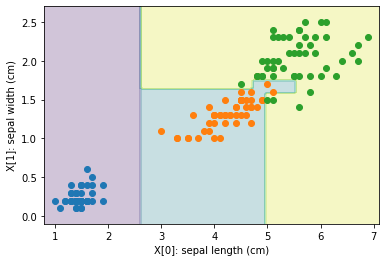

Modelo:  Arvore2()


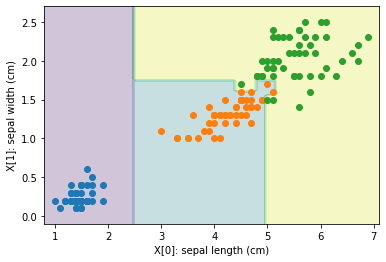

Modelo:  DecisionTreeClassifier()


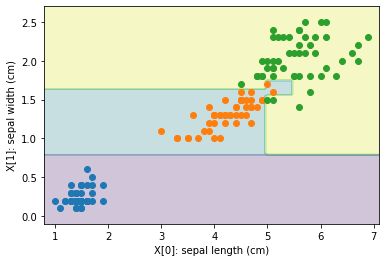

Modelo:  KNeighborsClassifier()


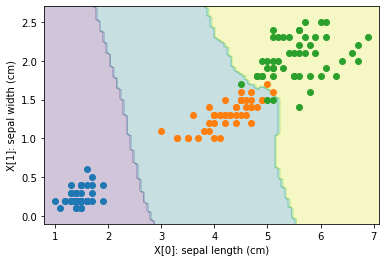

Modelo:  LogisticRegression()


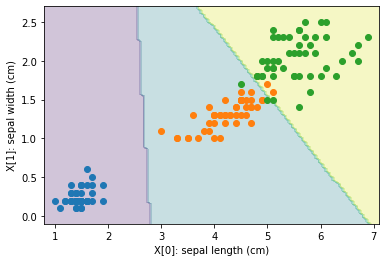

In [12]:
for Algoritmo in [Arvore1, Arvore2, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression]:
    modelo = Algoritmo()
    print("Modelo: ", modelo)
    plotDecisao(modelo, X, y)

In [13]:
import pandas as pd
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00537/sobar-72.csv")
X, y = df.iloc[:, :6], df.iloc[:, -1]
X.shape, y.shape

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=42)
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((54, 6), (18, 6), (54,), (18,))

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


for Algoritmo in [KNeighborsClassifier, GaussianNB, Perceptron, DecisionTreeClassifier, RandomForestClassifier]:
    modelo = Algoritmo()
    modelo.fit(X_tr, y_tr)
    y_pr = modelo.predict(X_te)
    hits = y_pr == y_te
    print(modelo, sum(hits)/len(hits))

KNeighborsClassifier() 0.7222222222222222
GaussianNB() 0.7777777777777778
Perceptron() 0.6111111111111112
DecisionTreeClassifier() 0.7222222222222222
RandomForestClassifier() 0.6666666666666666


In [15]:
from sklearn.model_selection import cross_validate
from sklearn import preprocessing

In [18]:
X, y = data[:,0::12], data[:,-1]
X = X.astype(str)
y = preprocessing.LabelEncoder().fit_transform(y)

In [17]:
data = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/00537/sobar-72.csv", dtype='str', delimiter=',')

X, y = data[1:10000,:2], data[1:10000,-1]
X = X.astype(float)
y = preprocessing.LabelEncoder().fit_transform(y)

for Algoritmo in [Arvore1, Arvore2, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression]:
    modelo = Algoritmo()
    print("Modelo: ", modelo)
    scores = cross_validate(modelo, X, y)
    print(scores['test_score'], np.mean(scores['test_score']))

Modelo:  Arvore1()
[0.73333333 0.8        0.78571429 0.71428571 0.64285714] 0.7352380952380952
Modelo:  Arvore2()
[0.73333333 0.8        0.78571429 0.71428571 0.64285714] 0.7352380952380952
Modelo:  DecisionTreeClassifier()
[0.73333333 0.8        0.78571429 0.71428571 0.64285714] 0.7352380952380952
Modelo:  KNeighborsClassifier()
[0.6        0.46666667 0.35714286 0.64285714 0.71428571] 0.5561904761904762
Modelo:  LogisticRegression()
[0.66666667 0.73333333 0.78571429 0.78571429 0.71428571] 0.7371428571428571


In [19]:
data = np.loadtxt('https://archive.ics.uci.edu/ml/machine-learning-databases/00537/sobar-72.csv', dtype='str', delimiter=',')
X, y = data[1:,[0, 3, 4, 7] ], data[1:,-1]
X = X.astype(int)
y = y.astype(float)

for Algoritmo in [Arvore1, Arvore2, DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression]:
    modelo = Algoritmo()
    print("Modelo: ", modelo)
    scores = cross_validate(modelo, X, y)
    print(scores['test_score'], np.mean(scores['test_score']))

Modelo:  Arvore1()
[0.6        0.53333333 0.85714286 0.57142857 0.64285714] 0.6409523809523809
Modelo:  Arvore2()
[0.73333333 0.66666667 0.78571429 0.5        0.57142857] 0.6514285714285715
Modelo:  DecisionTreeClassifier()
[0.6        0.73333333 0.78571429 0.5        0.64285714] 0.6523809523809524
Modelo:  KNeighborsClassifier()
[0.6        0.4        0.71428571 0.64285714 0.71428571] 0.6142857142857143
Modelo:  LogisticRegression()
[0.86666667 0.6        0.78571429 0.57142857 0.85714286] 0.7361904761904762
